In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import os, sys
sys.path.append(os.getcwd() + "/../src")

%load_ext autoreload
%autoreload 2

In [2]:
import networkx as nx
import numpy as np
import handl
import util
from collections import defaultdict

### Generating random graph with arbitrary degree sequence

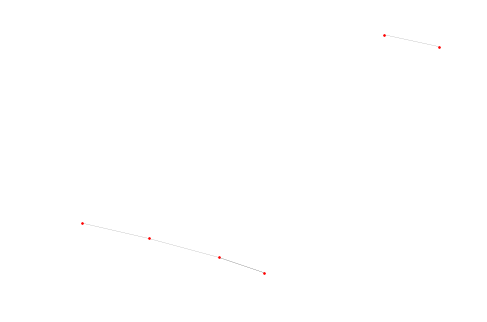

In [3]:
def draw_random1():
    degree_sequence = [1,3,2,3,2,1]
    G = nx.configuration_model(degree_sequence)
    nx.draw_spring(G, node_shape='.', node_size=10, width=0.1)
draw_random1()

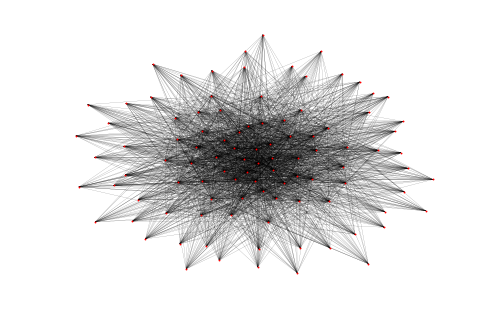

In [4]:
def draw_random2():
    G = nx.barabasi_albert_graph(100, 50)
    nx.draw(G, node_shape='.', node_size=3, width=0.1)
draw_random2()

In [5]:
def draw(G):
    nx.draw(G, node_shape='.', node_size=3, width=0.1)

### Load large graphs...

In [6]:
sp_ppi_path = "../data/ppi/biogrid/sp/sp-biogrid.v3.4.157-ppi-std.tsv" 
sc_ppi_path = "../data/ppi/biogrid/sc/sc-biogrid.v3.4.157-ppi-std.tsv" 
sp_G = util.simple_two_core(nx.read_edgelist(sp_ppi_path, encoding='ascii'))
sc_G = util.simple_two_core(nx.read_edgelist(sc_ppi_path, encoding='ascii'))

2018-02-20 17:10:59,183 util.py         WARNING   : Network has 109 connected components
2018-02-20 17:10:59,184 util.py         WARNING   : 	Largest is size 2678 and all the rest are 6 or smaller
2018-02-20 17:10:59,185 util.py         WARNING   : 	Using largest connected component
2018-02-20 17:10:59,192 util.py         INFO      : PPI info - # Nodes: 2678, # Edges: 8525
2018-02-20 17:10:59,193 util.py         INFO      : Computing 2 core
2018-02-20 17:10:59,356 util.py         INFO      : 2 core info - # Nodes: 1865, # Edges: 7712
2018-02-20 17:10:59,357 util.py         INFO      : 2 core removed 813 nodes and 813 edges
2018-02-20 17:10:59,825 util.py         INFO      : PPI info - # Nodes: 5751, # Edges: 96139
2018-02-20 17:10:59,825 util.py         INFO      : Computing 2 core
2018-02-20 17:11:01,557 util.py         INFO      : 2 core info - # Nodes: 5609, # Edges: 95997
2018-02-20 17:11:01,558 util.py         INFO      : 2 core removed 142 nodes and 142 edges


Let's draw the _S.p_ PPI network just for fun:

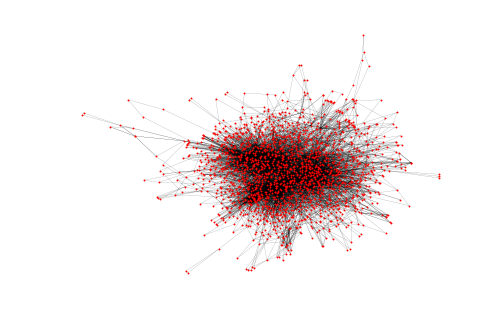

In [7]:
draw(sp_G)

### Manipulating the degree sequence...

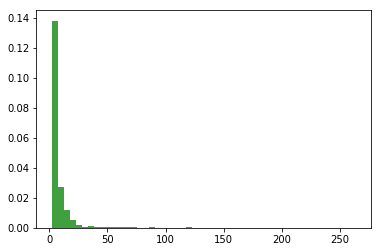

In [8]:
sp_deg_sequence = list(sp_G.degree)
nodes, degrees = zip(*sp_deg_sequence)
hist = plt.hist(degrees,50, normed=1, facecolor='green', alpha=0.75)

In [9]:

def shuffle(arr):
    ''' Copy and shuffle given list'''
    arr_copy = arr[:]
    np.random.shuffle(arr_copy)
    return arr_copy

def get_degree_to_names(tuples):
    ''' Returns dictionary of degrees to node names from given list of (name, deg) tuples '''
    d = defaultdict(list)
    for  name, deg in tuples:
        d[deg].append(name)
    return d

def get_degree_preserving_relabelling(new_name_dict, unlabeled_G):
    ''' Returns name mapping given between degree to node names dictionary and unlabeled graph G'''
    old_degree_dict = get_degree_to_names(unlabeled_G.degree)
    mapping_tuples = []
    for deg, new_names in new_name_dict.items():
        old_names = old_degree_dict[deg]
        mapping_tuples += (list(zip(old_names, shuffle(new_names))))
    return dict(mapping_tuples)

def perturbed_graph(seed_graph):
    ''' Returns random graph with approximately the same degree distribution as given seed graph'''
    # Generate new graph with given degree sequence
    deg_sequence = shuffle(list(seed_graph.degree))
    new_G = nx.configuration_model(list(zip(*deg_sequence))[1])
    
    # Rename graph with nodes in seed_graph with corresponding degrees
    deg2names = get_degree_to_names(deg_sequence)
    mapping = get_degree_preserving_relabelling(deg2names, new_G)
    new_G = nx.relabel_nodes(new_G, mapping)
    
    # Remove self loops and parallel edges and return
    return util.simple_two_core(nx.Graph(new_G))

def safe_perturbed_graph(seed_graph, n_tries=10):
    for i in range(n_tries):
        new_G = perturbed_graph(seed_graph)
        if len(not_shared_nodes(new_G, seed_graph)) == 0:
            return new_G
    raise Exception()

def not_shared_nodes(G1, G2):
    return set(G1.nodes) ^ set(G2.nodes)

In [10]:
new_G = safe_perturbed_graph(sp_G)

2018-02-20 17:11:24,631 util.py         INFO      : PPI info - # Nodes: 1865, # Edges: 7376
2018-02-20 17:11:24,632 util.py         INFO      : Computing 2 core
2018-02-20 17:11:24,761 util.py         INFO      : 2 core info - # Nodes: 1864, # Edges: 7375
2018-02-20 17:11:24,763 util.py         INFO      : 2 core removed 1 nodes and 1 edges
2018-02-20 17:11:25,034 util.py         INFO      : PPI info - # Nodes: 1865, # Edges: 7415
2018-02-20 17:11:25,034 util.py         INFO      : Computing 2 core
2018-02-20 17:11:25,144 util.py         INFO      : 2 core info - # Nodes: 1864, # Edges: 7414
2018-02-20 17:11:25,145 util.py         INFO      : 2 core removed 1 nodes and 1 edges
2018-02-20 17:11:25,353 util.py         INFO      : PPI info - # Nodes: 1865, # Edges: 7445
2018-02-20 17:11:25,354 util.py         INFO      : Computing 2 core
2018-02-20 17:11:25,472 util.py         INFO      : 2 core info - # Nodes: 1865, # Edges: 7445
2018-02-20 17:11:25,473 util.py         INFO      : 2 core

### Some sanity checks
* Qualitative: check that the degree distributions look the same
* Quantitative: record the maximum and mean difference in degrees

In [11]:
def degree_distribution(G1, G2):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    deg_sequence1 = list(G1.degree)
    _, degrees1 = zip(*deg_sequence1)
    hist1 = ax1.hist(degrees,50, normed=1, facecolor='green', alpha=0.75)
    ax1.set_title("Degree distribution 1")
    deg_sequence2 = list(G2.degree)
    _, degrees2 = zip(*deg_sequence2)
    hist1 = ax2.hist(degrees,50, normed=1, facecolor='green', alpha=0.75)
    ax2.set_title("Degree distribution 2")


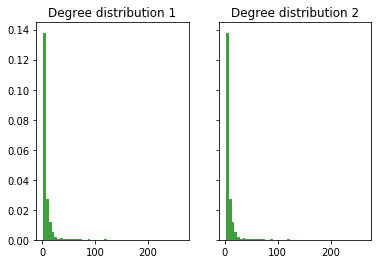

In [12]:
degree_distribution(new_G, sp_G)

See if there are nodes that have been removed as a result of removing self loops and parallel edges from the random graph

In [13]:
def not_shared_nodes(G1, G2):
    return set(G1.nodes) ^ set(G2.nodes)

In [14]:
not_shared_nodes(new_G, sp_G)

set()

In [15]:
def degree_differences(G1, G2):
    G1_degs = dict(G1.degree)
    G2_degs = dict(G2.degree)
    diffs = []
    for node, deg1 in G1_degs.items():
        diffs.append(deg1 - G2_degs[node])
    return diffs

46
0.28632707774798927


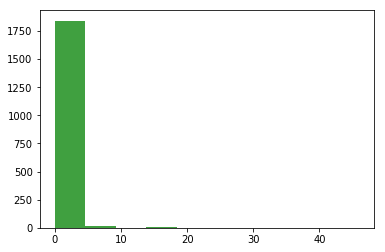

In [16]:
diffs = degree_differences(sp_G, new_G)
diff_hist = plt.hist(diffs, facecolor='green', alpha=0.75)
print(max(diffs))
print(np.mean(diffs))

### Running HANDL on perturbed graph

In [17]:
# Load PPI and HOMOLOG data
sp_ppi_path = "../data/ppi/biogrid/sp/sp-biogrid.v3.4.157-ppi-std.tsv" 
sc_ppi_path = "../data/ppi/biogrid/sc/sc-biogrid.v3.4.157-ppi-std.tsv" 
homologs_path = "../data/homologs/sc-sp/sc-sp-homologs.txt" 
sp_G = util.simple_two_core(nx.read_edgelist(sp_ppi_path, encoding='ascii'))
sc_G = util.simple_two_core(nx.read_edgelist(sc_ppi_path, encoding='ascii'))
homologs = handl.homologs_in_graphs(sc_G, sp_G, util.read_homolog_list(homologs_path))

2018-02-20 17:12:09,313 util.py         WARNING   : Network has 109 connected components
2018-02-20 17:12:09,314 util.py         WARNING   : 	Largest is size 2678 and all the rest are 6 or smaller
2018-02-20 17:12:09,314 util.py         WARNING   : 	Using largest connected component
2018-02-20 17:12:09,323 util.py         INFO      : PPI info - # Nodes: 2678, # Edges: 8525
2018-02-20 17:12:09,324 util.py         INFO      : Computing 2 core
2018-02-20 17:12:09,493 util.py         INFO      : 2 core info - # Nodes: 1865, # Edges: 7712
2018-02-20 17:12:09,494 util.py         INFO      : 2 core removed 813 nodes and 813 edges
2018-02-20 17:12:10,119 util.py         INFO      : PPI info - # Nodes: 5751, # Edges: 96139
2018-02-20 17:12:10,121 util.py         INFO      : Computing 2 core
2018-02-20 17:12:12,366 util.py         INFO      : 2 core info - # Nodes: 5609, # Edges: 95997
2018-02-20 17:12:12,367 util.py         INFO      : 2 core removed 142 nodes and 142 edges


In [18]:
def seperate_dissimilarity_scores(dissim_scores, 
                                  landmark_pair_idxs, homolog_pair_idxs):
    source_landmark_idxs, target_landmark_idxs = zip(*landmark_pair_idxs)
    source_homolog_idxs, target_homolog_idxs = zip(*homolog_pair_idxs)
    landmark_mask = np.zeros_like(dissim_scores, dtype=bool)
    landmark_mask[source_landmark_idxs, target_landmark_idxs] = True
    
    homolog_mask = np.zeros_like(dissim_scores, dtype=bool)
    homolog_mask[source_homolog_idxs, target_homolog_idxs] = True
    
    # Obtain non-landmark homolog scores
    nlh_mask = np.ones_like(dissim_scores, dtype=np.bool)
    nlh_mask &= homolog_mask # all homologs
    nlh_mask &= ~landmark_mask # all not landmarks
    NLH_scores = dissim_scores[nlh_mask]
    
    # Obtain non-homolog scores, 
    # excluding all rows and columns corresponding to landmarks
    other_mask = np.ones_like(dissim_scores, dtype=bool)
    other_mask &= ~homolog_mask # all not homologs
    other_mask &= ~landmark_mask # all not landmarks
    non_homolog_scores = dissim_scores[other_mask]

    return NLH_scores, non_homolog_scores

def handl_dissimilarity_scores(source_G, target_G, homologs):
    # Calculate handl similarity scores
    outputs = handl.handl_embed_graphs(source_G, target_G, homologs,n_landmarks=400, return_idxs=True)
    ((source_C, source_nodes), (target_C_hat, target_nodes), landmark_idxs, homolog_idxs) = outputs
    non_landmark_hom_idxs = set(homolog_idxs)  - set(landmark_idxs)
    handl_similarity_scores = source_C.dot(target_C_hat.T)
    dissimilarity_scores = 1. / homolog_similarity_scores
    dissimilarity_scores /= np.mean(dissimilarity_scores)
    homolog_dissimilarity_scores, other_dissmililarity_scores = \
    seperate_dissimilarity_scores(dissimilarity_scores, 
                                  landmark_idxs, homolog_idxs)
    return homolog_dissimilarity_scores, dissimilarity_scores

In [19]:
def plot(NLH, D):
    from sklearn import neighbors
    xmax = 0.6
    # create kernel density estimator
    kde = neighbors.KernelDensity(kernel='gaussian',
                                              bandwidth = xmax / 20.)
    # need to add another dimension as required by sklearn
    # arrays passed to kde must be 2-dimensional
    X_plot = np.reshape(np.linspace(0, xmax, 500), (-1, 1))

    # Density of non-landmark homolog pairs
    kde.fit(np.reshape(np.ravel(NLH), (-1, 1)))
    NLHdens = kde.score_samples(X_plot)

    # Density of all pairs
    Dsamp = np.random.choice(np.ravel(D),100000)
    kde.fit(np.reshape(Dsamp, (-1, 1)))
    Ddens = kde.score_samples(X_plot)

    # create and save plot
    font_size = 20
    line_width = 3
    plt.figure()
    plt.plot(X_plot[:,0], np.exp(NLHdens), lw = line_width,
                 label = 'Homolog Pairs')
    plt.plot(X_plot[:,0], np.exp(Ddens), '-.',
                 lw = line_width, ls = (0,(5,2)), label = 'Non-homolog Pairs')
    plt.ylabel('Density', size = font_size)
    plt.xlabel('HANDL dissimilarity', size = font_size)
    plt.legend(loc='best', fontsize = font_size)

In [ ]:
homolog_dissimilarity_scores, dissimilarity_scores = handl_dissimilarity_scores(sc_G, sp_G, homologs)
plot(homolog_dissimilarity_scores, dissimilarity_scores)

In [ ]:
print(np.mean(homolog_dissimilarity_scores))
print(np.mean(dissimilarity_scores))

### Measuring the significance of actual HANDL dissimilarities

To measure whether or not the observed difference in means from HANDL is signficant we perform a permutation test:

Null hypothesis: There is no difference in means between HANDL dissimilarity scores of homologs and non-homologs (in random graphs conditioned on fixed degree distributions.)

Fast procedure to generate random graph (using nx.configuration model):
1. Generate graph, G, with fixed degree distributions from real PPI
2. Label graph with proteins with corresponding degrees in real PPI
3. Remove self loops, parallel edges and perform 2-Core
4. If no nodes have been removed as a result of 3: Return G
6. Else: Go to 1.

Permutation test:
0. Compute actual difference in mean dissimilarity between homologs and non homologs, $\delta$
1. Generate N random pairs of graphs given real source and target PPI pair
2. Compute HANDL dissimilarities for homologs and non-homologs
3. Compute differences in means of dissimilarities for the N trials
4. Count the number of differences in means in N trails that are less than $\delta$, $M$
5. Report p-value $\frac M N$ with corresponding confidence interval.



In [ ]:
rand_sc_G = safe_perturbed_graph(sc_G)
rand_sp_G = safe_perturbed_graph(sp_G)
rand_hom_scores, rand_scores = handl_dissimilarity_scores(rand_sc_G, rand_sp_G, homologs)
plot(rand_hom_scores, rand_scores)

In [ ]:
print(np.mean(rand_hom_scores))
print(np.mean(rand_scores))

### HANDL dissimilarity for jumbled graphs for many iterations

In [ ]:
def sample_random_handl_means(source_G, target_G, homologs, n_trials = 100):
    hom_means = []
    non_hom_means = []
    for i in range(n_trials):
        rand_source_G = safe_perturbed_graph(source_G)
        rand_target_G = safe_perturbed_graph(target_G)
        rand_hom_scores, rand_scores = handl_dissimilarity_scores(rand_source_G, rand_target_G, homologs)
        hom_means.append(np.mean(rand_hom_scores))
        non_hom_means.append(np.mean(rand_scores))
    return hom_means, non_hom_means

In [ ]:
small_sample_means = sample_random_handl_means(sc_G, sp_G, homologs, n_trials=5)

In [ ]:
print(small_sample_means)

In [ ]:
big_sample_means = sample_random_handl_means(sc_G, sp_G, homologs, n_trials=10)

Permute the label amongst high degree nodes? Correcting for homologs being higher degree
Q: are homologs higher degree

In [ ]:
print(big_sample_means)

In [ ]:
diff_means = np.asarray(big_sample_means[0]) - np.asarray(big_sample_means[1])

In [ ]:
observed_diff = np.mean(homolog_dissimilarity_scores) - np.mean(dissimilarity_scores)
print('p-val', np.sum(diff_means < observed_diff) / len(diff_means))

### Some data exploration w.r.t homolog degree distributions...

In [ ]:
sc_homs, sp_homs = list(zip(*homologs))

In [ ]:
sp_hom_degrees = [deg for node, deg in sp_G.degree(sp_homs)]
sc_hom_degrees = [deg for node, deg in sc_G.degree(sc_homs)]
sp_degrees = [deg for node, deg in sp_G.degree if node not in set(sp_homs)]
sc_degrees = [deg for node, deg in sc_G.degree if node not in set(sc_homs)]

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
_ = ax1.hist(sp_hom_degrees,50, normed=1, facecolor='green', alpha=0.75)
_ = ax1.set_title("S.p homologs")
_ = ax2.hist(sp_degrees,50, normed=1, facecolor='green', alpha=0.75)
_ = ax2.set_title("S.p non-homologs")
print('difference in homolog vs non-homolog mean degrees', np.mean(sp_hom_degrees) - np.mean(sp_degrees))

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
_ = ax1.hist(sc_hom_degrees,50, normed=1, facecolor='green', alpha=0.75)
_ = ax1.set_title("S.c homologs")
_ = ax2.hist(sc_degrees,50, normed=1, facecolor='green', alpha=0.75)
_ = ax2.set_title("S.c non-homologs")
print('difference in homolog vs non-homolog mean degrees', np.mean(sc_hom_degrees) - np.mean(sc_degrees))